In [1]:
%pylab inline
figsize(10,10)

from random import *
import scipy.io
from sklearn.linear_model import Lasso, LassoCV, lasso_path, Ridge
from sklearn import datasets

Populating the interactive namespace from numpy and matplotlib


**1** Hight dimensional regression
**1.1** Lasso

**Create a sample** of size $n=100$ of points $(X_i,Y_i)$ with $X_i\in\mathbb R^p$ and $Y_i\in\mathbb R$, and satisfying
$$Y_i=\langle \theta, X_i\rangle+\epsilon_i=\sum_k\theta_kX_i^k+\epsilon_i$$
with $\theta\in\mathbb R^p$ sparse, containing only $s=10$ nonzero entries $\theta_k\neq 0$, and some noise $\epsilon_i$ distributed according to the normal law $\mathcal N(0,1)$, $i=1,\dots,n$.


In [2]:
n = 100
p = 30
s = 10

THETA = zeros(p)
nonzeros = 0

while nonzeros < s :
    
    position = randint(0,p-1)
    
    if THETA[position] == 0 :
        
        nonzeros += 1
        THETA[position] = random()

X = array([normal(0,5,p) for i in range(n)])

epsilon = normal(0,1,n)

Y = X.dot(THETA) + epsilon

We are interested in using the Lasso, with the minimization of
$$f_\lambda(\theta)=\frac{1}{2 n}\|Y-\langle X,\theta\rangle\|^2_2+\lambda\|\theta\|_1=\frac{1}{2 n}\sum_{i=1}^n\left(Y_i-\sum_{k=1}^pX_i^k\theta_k\right)^2+\lambda\sum_{i=1}^p|\theta_i|$$~
where $\lambda$ is a positive parameter.

**Write down the main step of minimization algorithm of $f_\lambda$.** (See Proposition 2.3.3.)

Our function of interest $f_\lambda(\theta)$ is not differentiable, so that we cannot minimize it using the gradient descent. 

Nonetheless we can decompose $f_\lambda(\theta)$ as a sum of a smooth and convex function : $f(\theta)$ and a continuous but non smooth function (involving norm 1).

$$f_\lambda(\theta) = \tilde{f}(\theta) + \lambda\|\theta\|_1$$

Then, for each coordinate of $\theta$ we define a sequence of surrogates and we build a sequence of the minimizers of each surrogates. This allows us to find the minimizer of our function. Indeed, the sequence of minimizers of the surrogates should converge toward the minimum of our function of interest.

The sequence of minimizers $(\theta_k)_k$ is build in such a way that to compute each value $(\theta_k)$ we have to solve a multidimensional problem. Indeed we need to find the minimizer $\theta$ in $\mathbb{R}^p$ of a sum of terms. But is suffices to solve the minimizer for each term of the sum to get each coordinate of the $\theta$ we are looking for, and then build the $\theta$.

$$f(\theta) =\|Y-\langle X,\theta\rangle\|^2_2 = \sum_{i=1}^n\left(Y_i-\sum_{k=1}^pX_i^k\theta_k\right)^2 = \sum_{i=1}^n Y_i + \sum_{i=1}^n \sum_{k=1}^p (X_i^k)^2(\theta_k)^2 + 2 \sum_{i=1}^n \sum_{l<k} X_i^l \theta_l X_i^k \theta_k - 2 Y_i \sum_{k=1}^p X_i^k \theta_k$$

$$\frac{\partial f(\theta)}{\partial \theta_q} = 2 \theta_q \sum_{i=1}^n (X_i^q)^2 + 2 \sum_{i=1}^n \sum_{k \neq q} X_i^q X_i^k \theta_k - 2 Y_i X_i^q$$

$$\frac{\partial f(\theta)^2}{\partial \theta_q \theta_r} = 2 \sum_{i=1}^n X_i^q X_i^r$$

$$\frac{\partial f(\theta)^2}{\partial \theta_q^2} = 2 \sum_{i=1}^n (X_i^q)^2$$

So $Hess_f = D^2f = 2 X^t X$, then L = $||Hess_f||_{frob} = \sqrt{\sum_{i=1}^n \sum_{j=1}^n {Hess_f}_{i,j} }$

Objective function is $f_\lambda(\theta)=\frac{1}{2 n}\|Y-\langle X,\theta\rangle\|^2_2+\lambda\|\theta\|_1$ but coordinate descent minimizes $f_\lambda(\theta)=\|Y-\langle X,\theta\rangle\|^2_2+\lambda\|\theta\|_1$ then we just need to sets $\lambda = 2 n \lambda$

**Program the Iterative Soft Thresholding Algorithm.**

In [3]:
def gradientApprox(f, x, eps = 10**(-5)):

    """ Here we approximate the derivative of f at each coordinate in the array x.
        The function return the array of the value of the different derivatives evaluated 
        at each value of the array x."""

    if type(x) != ndarray:
        x = array(x)
    gradient = zeros(x.shape)

    for i in range(x.shape[0]):

        vect_eps = zeros(x.shape)
        np.put(vect_eps,i,eps)
        gradient[i] = ( f(x+vect_eps)-f(x) ) / eps

    return gradient 

def methodNormeGrad(f, X0, alpha, tol, N=2000):
    
    """ The purpose is to estimate the extrema point X of the function f.
    
        1rst we initialize the gradient for the initial values in array X0,
        and we initialize the value of the estimated extrema point X with initial values X0.
        
        2nd we enter a loop until the gradients converges in norm to 0 
        (or until the max number of iterations is reached).
        
        In this loop, we update the estimated point by substracting a deviation from the previous gradient
        making the gradient smaller.
        Then we update the gradient and each time we save its norm in the array lnormg so that we are 
        able in the end to see the convergence of the norm to 0. 
        
        The function return the estimated extrema point, the array of norms 
        and the sequence of successive result until convergence. """
    
    lX=[X0]
    X = X0
    g = gradientApprox(f,X0)
    lnormeg = [norm(g)]
    
    n=0
    
    while norm(g) > tol and n < N:
        
        X = X - alpha*g
        g = gradientApprox(f,X)
        lnormeg.append(norm(g))
        lX.append(X)
        n += 1
        
    if n==N:
        
        print(f"Max number of iterations {N}")
        
    return X, array(lnormeg), array(lX)

def soft_thresholding_op(x, lbda, L):
    
    return sign(x)*maximum(0, abs(x) - lbda/L)

def ISTA(f, x0, lbda, L, tolerance = 10**(-5), N = 1000):
    
    """ We do a gradient descent on f in order to get Xk the argmin vector we want to build.
        To do so, we build each coordinate of the vector using the soft thresholding operator (given in prop. 2.3.3).
        The soft thresholding operator is applied on Xk_tilde obtainded by the gradient descent algorithm. """
    
    xk = x0.copy()
    xk_tilde = x0.copy()
    
    grad = gradientApprox(f, x0)
    
    diff = [100]
    
    n = 0
    
    while diff[-1] > tolerance and n < N :
        
        xk_ = xk
        
        xk_tilde = xk - grad/L
        xk = soft_thresholding_op(xk_tilde, lbda, L)

        grad = gradientApprox(f, xk)
        
        diff.append(norm(xk_ - xk))
        
        n += 1
        
    if n == N :
        print(f"Max number of iterations {N}")
    
    return xk, diff

def smooth_convex_f(x, features = X, labels = Y):
    
    s = 0
    for l in range(features.shape[0]):
        scalar_features_x = 0
        for k in range(features.shape[1]):
            scalar_features_x += features[l,k]*x[k]
        s += (labels[l] - scalar_features_x)**2
        
    return s

**Test your implementation of ISTA to find $\theta$ from $X$ and $Y$ above.**

**Compare your result with the *sklearn.linear_model* package.** Help yourself with the resources you find on the web. Note that the parameter `alpha` taken by `Lasso` is equal to $\lambda$ in our notation.

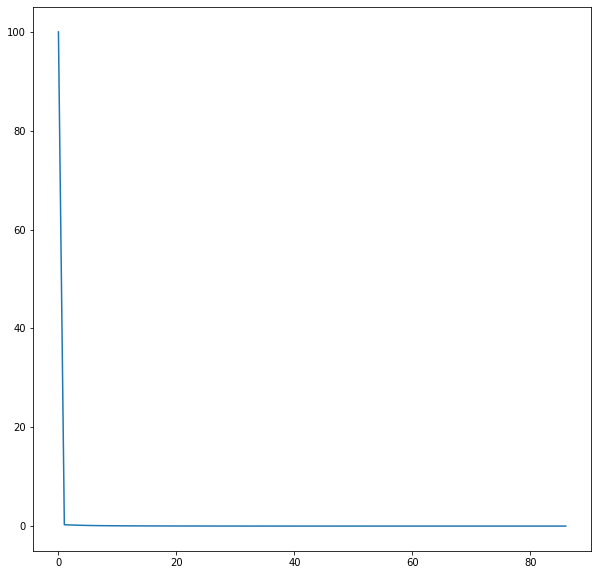

In [4]:
# With 1st theta = null vector

Lips_cst = linalg.norm(2*np.dot(X.T,X))
penalty_term_lbda = 2.*X.shape[0]*2

result, successive_norms_grad = ISTA(smooth_convex_f, zeros(p), penalty_term_lbda, Lips_cst)

plot(successive_norms_grad)

In [5]:
print(f"The theta we are trying to recover \n{THETA}\n")

print(f"Result from ISTA program \n{result}\n")

lasso = Lasso(alpha = 2.)
lasso_fit = lasso.fit(X,Y)

print(f"Result from LASSO program (sklearn) \n{lasso_fit.coef_ - zeros(p)}\n")

The theta we are trying to recover 
[0.24931202 0.         0.88730906 0.31643074 0.         0.
 0.92933529 0.         0.         0.         0.85173348 0.
 0.03552247 0.         0.         0.         0.2482205  0.9006299
 0.82400411 0.         0.         0.         0.         0.
 0.04742571 0.         0.         0.         0.         0.        ]

Result from ISTA program 
[ 0.19317873  0.          0.81862155  0.22346864 -0.         -0.
  0.835422    0.         -0.         -0.          0.75610201 -0.
  0.          0.         -0.         -0.          0.16097486  0.78144706
  0.7559985  -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.        ]

Result from LASSO program (sklearn) 
[ 0.19415586  0.          0.81824069  0.2215504  -0.         -0.
  0.8342829   0.         -0.         -0.          0.75415699 -0.
  0.          0.         -0.         -0.          0.16178154  0.78238155
  0.75729232 -0.         -0.          0.   

The results are similar but the ISTA program does not really converges since the norms of gradient at the end are still quite high. The convergence seems to depend on the initial point chosen.

Nonetheless the result from the ISTA are closed to the one from the LASSO of sklearn. The LASSO from sklearn use a particularly complexe criterion of convergence which is not implemented here. This could explain the eventual differences between both methods.

**1.2** Application to a real database

**Use a real database from *scikit-learn* and test your program and the package *sklearn.linear_model*.**

Note that the parameter `alpha` taken by `Lasso` is equal to $\lambda$ in our notation.

In [6]:
IRIS = datasets.load_iris()

def f(x, features = IRIS.data, labels = IRIS.target):
    
    s = 0
    for l in range(features.shape[0]):
        scalar_features_x = 0
        for k in range(features.shape[1]):
            scalar_features_x += features[l,k]*x[k]
        s += (labels[l] - scalar_features_x)**2
        
    return s

lasso = Lasso(alpha=0.9)
u = lasso.fit(IRIS.data,IRIS.target)

Lips_cst = linalg.norm(2*np.dot(IRIS.data.T,IRIS.data))
penalty_term_lbda = 0.9*IRIS.data.shape[0]*2

iris_result, successive_norms_grad = ISTA(f, zeros(IRIS.data.shape[1]), penalty_term_lbda, Lips_cst)

iris_result

array([0.        , 0.        , 0.24514151, 0.        ])

In [7]:
lasso = Lasso(alpha = 0.9)
lasso_fit = lasso.fit(IRIS.data, IRIS.target)

print(lasso_fit.coef_ - zeros(IRIS.data.shape[1]))

[ 0.         -0.          0.14967951  0.        ]


Here the results are much different than before. As the criterion of convergence from the Lasso regression of sklearn is something really complicated that we do not implement here the result could be different. The ratio number of features/size of the sample before was aroud 1/3 since the sample was of size 100 and we had 30 features ; here the sample has size 150 with 4 different features. It could also be a reason why it does not give a result as good as before.

**Use your lecture notes to check what is ridge regression. Explain briefly the pros and cons associated to this method, especially when handling high dimensional datasets.**

Studying the issues raised by linear regression in high dimension we conclude that the usual OLS estimator is no longer consistent when the number of features is higher than the size of the sample.

Instead of the usual minimization program $$\hat{\theta_n} = \underset{\theta \in \mathbb{R^p}}{argmin} \|Y-\langle X,\theta\rangle\|_2^2$$ we add a penalty term to the minimization $$\hat{\theta}_{Ridge} = \underset{\theta \in \mathbb{R^p}}{argmin} \|Y-\langle X,\theta\rangle\|_2^2 + \lambda\|\theta\|_2^2$$

It results in a good estimator in the context of reasonnable dimensional problems with multi-colinearity among the covariates. The ridge regression has a good numerical stability. The purpose of adding a penalty term is to penalize the size of the coefficient $\theta$ in order to reduce the variance of the estimates. The trade-off variance/bias implies that it increases the bias because of the penalty term $\lambda$. This bias can be removed only with not so high dimension (when the size of the sample stay superior to the number of features), it is the reason why we should not use this method with high dimensions.

**Compare the results (from a statistical and numerical point of
view) between the Lasso and the Ridge regression.**

In [8]:
lasso_reg = Lasso(alpha=2.)
lasso_reg.fit(X,Y)
print(lasso_reg.coef_)
y_pred1 = lasso_reg.predict(X)
y_pred1

[ 0.19415586  0.          0.81824069  0.2215504  -0.         -0.
  0.8342829   0.         -0.         -0.          0.75415699 -0.
  0.          0.         -0.         -0.          0.16178154  0.78238155
  0.75729232 -0.         -0.          0.         -0.         -0.
  0.         -0.          0.          0.         -0.         -0.        ]


array([  3.00696719, -12.49919603,  -5.22415542, -15.54982089,
       -26.77243738,   1.43050917,   1.95807211, -10.4583002 ,
         1.58545486,  -4.17763745, -11.734608  ,   3.86397336,
         1.83769316,  12.66647634,   7.4716018 ,  -3.31829174,
        -3.3847816 , -10.5376289 ,  11.13871245,  -2.76526347,
        -3.65770603,   4.70463703,  -2.79658791,   9.22542996,
        -3.05959315,  -6.87757542, -16.04464161,  -7.82251363,
         7.85076293,  -1.15995759,  -0.1782063 ,   1.30784942,
         7.52359911,   0.31165546,  -5.78375249,  18.21905383,
        12.57493779, -13.74642306,  11.11637814,  -5.58406962,
        -3.94498922,   6.28237205,   2.58042838,   1.11418927,
         6.62064659,   0.50401677,  -2.52470847,  18.0150457 ,
         5.62905965, -10.39430596,   1.66538506,  -1.18856561,
        -0.71212679, -12.27926148,  -7.52250582,   1.80636521,
        13.70037287,  -2.47856015,   2.20777124, -10.51962303,
        -2.01907018,   0.44399266,   4.82219043, -16.51

In [9]:
ridge_reg = Ridge(alpha=.0001)
ridge_reg.fit(X,Y)
print(ridge_reg.coef_)
y_pred2 = ridge_reg.predict(X)
y_pred2

[ 0.24421283  0.02236298  0.90800354  0.30728509  0.00269417  0.00744762
  0.97906572 -0.02310187 -0.02715852 -0.00974144  0.84256456 -0.04119855
  0.08406956  0.01790343  0.02415629  0.01528229  0.25287328  0.88181197
  0.82691516 -0.0260512  -0.02837423  0.05380915 -0.04520337  0.01130601
  0.02618924 -0.00567473  0.00518743 -0.00636922 -0.04003144 -0.03082898]


array([  3.38599255, -13.78789398,  -6.10304864, -17.84072575,
       -28.83292037,   1.91428436,   2.41388415, -11.83950955,
         1.56911736,  -5.81312573, -14.19162476,   4.16150898,
         0.5001059 ,  14.31164275,   6.80449275,  -3.90300537,
        -4.63062037, -13.84219188,  11.81023858,  -2.58336152,
        -4.8722998 ,   4.01208982,  -2.1494691 ,  11.42571502,
        -4.8299499 ,  -5.1916575 , -18.21505027,  -9.43852554,
         8.95244327,  -1.8162852 ,   0.12419614,   1.38177988,
         8.58391498,  -0.57027618,  -5.62309412,  19.81024113,
        13.44819766, -16.95481064,  12.95558369,  -6.72676268,
        -3.6472661 ,   6.48152208,   3.77551388,   0.82890935,
         7.09553408,   1.69998611,  -3.3850574 ,  21.12112591,
         5.85016775, -11.50004429,   2.65812362,  -1.4433448 ,
        -0.40574808, -14.19283469,  -7.76574292,   2.06481058,
        15.25618597,  -3.44934431,   3.74097184, -11.21369974,
        -3.09004865,   0.47569564,   3.48992326, -18.11

The result of the coefficients from the ridge regression are not sparse and really different form the ones returned by the lasso. 

The ridge aim to converge quikly since the lasso is based on some more "efficiency" based criteria. This could explain that the ridge result do not take the for expected.

Nonetheless the prediction power seems not so far from the lasso since given the features X, both functions return similar values for the prediction of the target Y.

**2** Sequential regression problem

The log-likelihood is
$$ \ell(\theta)=\frac{\ell_n(\theta)}{n}=\frac1n\log\mathbb P((X_1,Y_1),\dots,(X_n,Y_n)|\theta)\\
=\frac1n\log\prod_{i=1}^n\frac{1}{1+e^{-Y_i\langle X_i,\theta\rangle}}\\
=-\frac1n\sum_{i=1}^n\log\left(1+e^{-Y_i\langle X_i,\theta\rangle}\right).
 $$
 **Why?**

We model $\mathbb{P}(Y=1|X=x) = p(x;\theta)$

$p(x;\theta) = \frac{e^{<\theta,x>}}{1 + e^{<\theta,x>}} = \frac{1}{1 + e^{-<\theta,x>}} = \frac{1}{1 + e^{-y<\theta,x>}}$

$\ell_n(\theta) = log \prod_{i = 1}^n \mathbb{P}(Y=1|X=x_i) = log \prod_{i = 1}^n p(x_i;\theta) = \sum_{i = 1}^n log(\frac{1}{1 + e^{-y_i<\theta,x_i>}}) = - \sum_{i = 1}^n log(1 + e^{-y_i<\theta,x_i>})$

Then $\ell(\theta)=\frac{\ell_n(\theta)}{n} = - \frac{1}{n} \sum_{i = 1}^n log(1 + e^{-y_i<\theta,x_i>})$

**Define a function that computes $\ell(\theta)$.**

In [10]:
def loglikelihood(theta, x, y):
    
    n = y.shape[0]
    s = 0
    for i in range(n):
        scalar = array([theta.dot(x[i,:])])
        expo = exp( - y[i] * scalar )
        s += math.log(1+ expo, 10)
    
    return - s / n

loglikelihood(THETA, X, Y)

-0.03415279029937272

**Is $\ell$, as a function of $\theta$, convex and/or smooth?**

$\ell$ is smooth as composite of smooth functions.

$\frac{\partial \ell(\theta)}{\partial \theta} = - \frac{1}{n} \sum_{i = 1}^n \frac{\partial}{\partial \theta} log(1 + e^{-y_i<\theta,x_i>}) = - \frac{1}{n} \sum_{i = 1}^n \frac{- y_i x_i e^{-y_i<\theta,x_i>}}{1 + e^{-y_i<\theta,x_i>}} = \frac{1}{n} \sum_{i = 1}^n \frac{y_i x_i}{1 + e^{y_i<\theta,x_i>}}$


$\frac{\partial^2 \ell(\theta)}{\partial \theta^2} = - \frac{1}{n} \sum_{i = 1}^n \frac{(y_i x_i)^2 e^{y_i<\theta,x_i>}}{(1 + e^{y_i<\theta,x_i>})^2}$ is minus the sum of positive terms so it is negative then $\ell$ is concave.

**Compute the gradient of $\ell$.** (Check your answer with page 39 of the notes.)

$\frac{\partial \ell(\theta)}{\partial \theta_k} = \frac{1}{n} \sum_{i = 1}^n x_i^k\frac{y_i}{1 + e^{y_i<\theta,x_i>}}$



In [11]:
def grad_loglikelihood(theta, x, y):
    
    n = y.shape[0]
    p = x.shape[1]
    gradient = zeros(p)
    
    for k in range(p):
        
        s = 0
        for i in range(n):
            scalar = array([theta.dot(x[i,:])])
            factor =  y[i] / (1 + exp( y[i] * scalar ))
            s += factor * x[i,k]
        
        gradient[k] = s
    
    return gradient

grad_loglikelihood(THETA, X, Y)

C:\Users\KU\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


array([  4.33439978,  -1.70115278,  -1.00328456,   1.55334132,
        -4.9800766 ,   2.10279101,  -3.23552813,   8.02937374,
         3.14970514,  -1.00421615,   1.80133781,  -4.71144242,
        -1.41744868,   0.46265804,  -0.03301158,  -1.65489513,
         1.51159355,   1.99870623,   1.76243286,  -5.02897811,
        -3.88687074,   0.16505242, -12.17186222,  -6.27074141,
         0.75633326,  -7.78571432,   1.81291502,  -0.6711048 ,
       -18.29602973,  -2.9245103 ])

**[Optional] Check that 
$$\theta^*=\operatorname{arg\,min}_{\theta\in\mathbb R^p}\ell(\theta).$$**

**Define a sequential stochastic gradient algorithm for the maximization of $\ell$:**
$$\theta_{n+1}=\theta_n+\gamma_{n+1}\nabla\ell(\theta_n)+\gamma_{n+1}\epsilon_{n+1}.$$
Note that in the definition below, `f` is a function to be maximized, `stepsizes` is a function (of `n`) giving the size of the step at each iteration.

According proposition 4.3.2 of the lecture notes, we choose here a stepsize $\gamma_n = \frac{\gamma}{n^{\alpha}}$ with $\gamma = \frac{1}{2}$ and $\alpha \in (0,1)$.

A (stochastic) gradient ascent aims to maximize a function whereas a gradient descent aims to minimize it. Here we program the stochastic gradient ascent, we will then implement it on the log likelihood of the logistic regression in order to find the maximizer.

In [12]:
def stochasticGradientAscent(f, x0, stepsize, alpha, tol, N = 5000):
    
    """ Here is the general formula of the stochastic gradient that we will apply later on the minimization of l.
        As usual we initialize our variable with x0 and enter the while loop to make the gradinet ascend converges.
        The new term is updated based on the stochastic gradient formula taking a noise into account."""
    
    x = x0
    g = gradientApprox(f,x0)
    lnormeg = [norm(g)]
    lX=[x]
    
    n=1
    
    while norm(g) > tol and n < N:
        
        noise = numpy.random.normal(0,1,x.shape[0])
        
        x = x + (1./n**alpha) * (stepsize*g + stepsize*noise)

        g = gradientApprox(f,x)
        
        lnormeg.append(norm(g))
        lX.append(x)
        
        n += 1
        
    if n==N:
        
        print(f"Max number of iterations {N}")
        
    return x, array(lnormeg), lX

**Give an admissible step sequence $(\gamma_n)_{n\geq1}$ for the convergence of $(\theta_n)_{n\geq1}$ towards $\theta^*$. Using the lecture notes, describe the theoretical properties with a convergence rate.**

From proposition 4.3.2 we know that an admissible stepsize $\gamma_n$ is $\frac{\gamma}{n^{\alpha}}$. Then with $\gamma \approx \frac{1}{2}$ and $\alpha \in (0,1)$ the bias and the variance of the estimation are bounded.

Hence the global rate of convergence of the method is lower than $\frac{1}{n}$.

**Program the sequential logistic regression algorithm and check its good behavior for reasonable size of $p$ ($p=5,10,20$).**

In [13]:
def logistic_regression(f, x0, gradient_f, target, features, stepsize=1/2, alpha=0.001, tol=10**(-6), N=10000):
    
    """ f and gradient_f input should be the loglikelihood function and its gradient.
    
        We base the sequential logistic regression on the stochastic gradient ascend method.
        First, we create the features and target (X and Y at the beginning of the TP).
        Then we initialize the gradient of the function with x0.
        While the norm of the gradient does not converge (or until we reach the maximum number of iterations),
        we compute the new term x based on the stochastic sequential formula.
        As usual, gradient is updated.
        The function return the sequence of x, the list of the successives norms of the gradient and the result x 
        which aim to be the minimizer of the convex function f. """

    x = x0
    g = gradient_f(x0, features, target)
    lnormeg = [norm(g)]
    lX=[x]
    
    k = 1
    
    while norm(g) > tol and k < N:
        
        noise = numpy.random.normal(0,1,x.shape[0])
        
        x = x +  (1./k**alpha) * (stepsize*g + stepsize*noise) 

        g = gradient_f(x, features, target)
        
        lnormeg.append(norm(g))
        lX.append(x)
        
        k += 1
        
    if k==N:
        
        print(f"Max number of iterations {N}")
        
    return x, array(lnormeg), lX

**Illustrate the convergence rate. Is it better than expected (from a theoretical point of view)?**

Let's represent in $\mathbb{R}^2$ the result from the logistic regression we built.

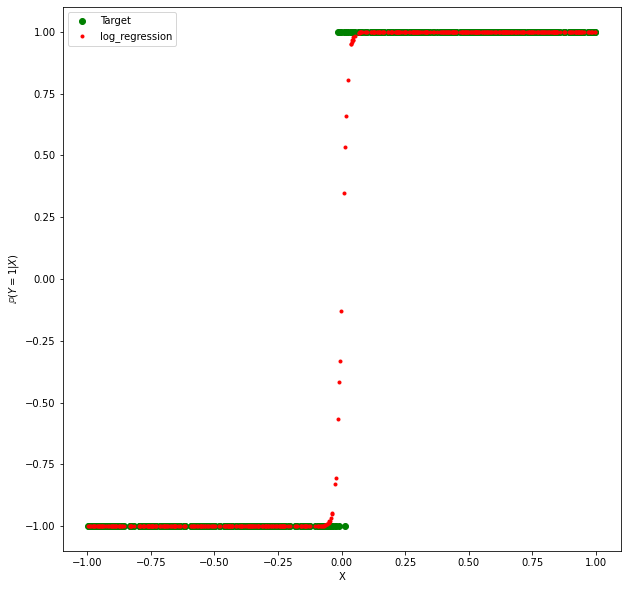

In [14]:
# SIMULATE
N = 500
features = np.random.uniform(-1, 1, size=N).reshape((-1,1))
true_theta = 85

scalar = true_theta * features
p = 1/(1 + np.exp(- scalar))

target = np.random.binomial(1, p) * 2 - 1
plot(features, target, 'go')

# GET ESTIMATES FROM LOGISTIC
theta_estimate, list_norms_R2, list_results_R2 = logistic_regression(loglikelihood, np.array([100]), grad_loglikelihood, target, features)

# PLOT THE FIT
scalar_estimate = theta_estimate * features
p_estimate = 1/(1 + np.exp(- scalar_estimate))
plot(features, p_estimate*2-1, "r.")

xlabel("X")
ylabel("$\mathbb{P}(Y=1|X)$")
legend(("Target","log_regression"))

Let's illustrate the convergence rate of the method applied on data generated in $\mathbb{R}^p$.

We generate data for p = 5, 10, 20 and apply the logistic regression ; we then look at the convergence rate and compare it with $\frac{1}{n}$.



For p = 5
Max number of iterations 1000


C:\Users\KU\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


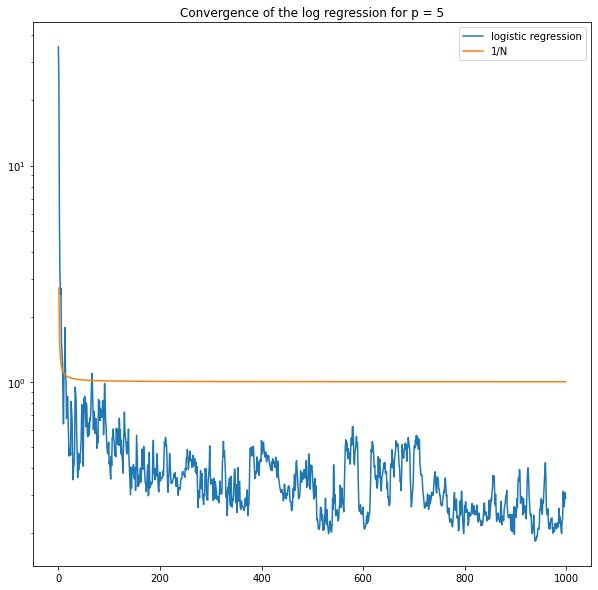

Max number of iterations 1000


C:\Users\KU\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


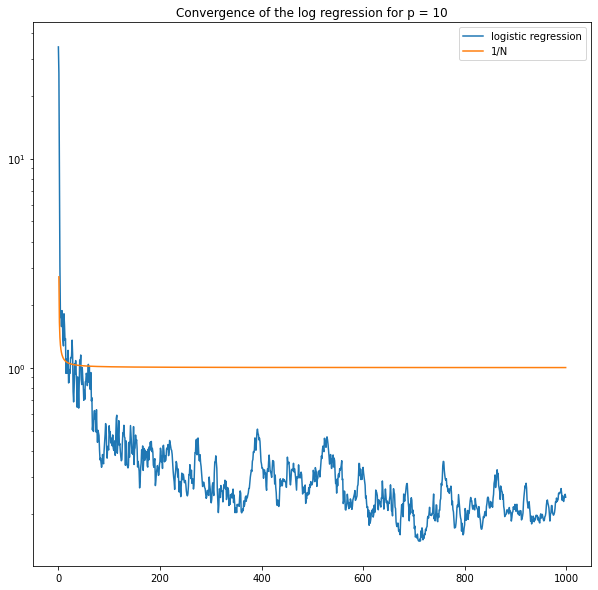

Max number of iterations 1000


C:\Users\KU\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide


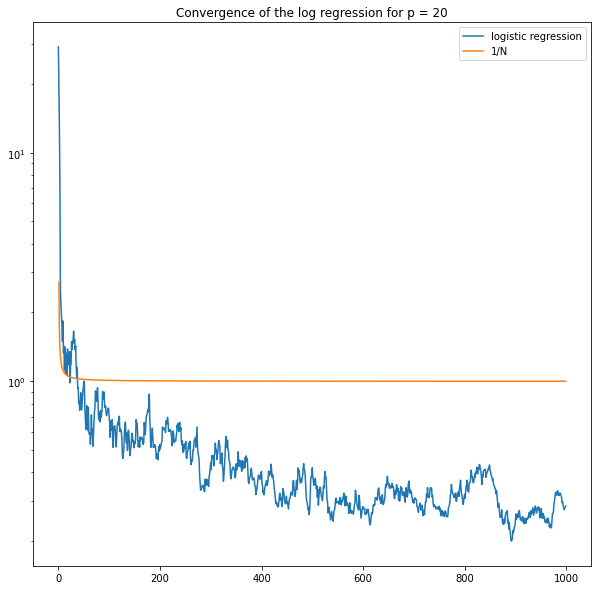

In [16]:
n = 100
p = 5

THETA = np.random.random(size=p+1)*50


X = np.concatenate((np.ones((n,1)), np.random.uniform(-1, 1, size=n*p).reshape((n,p))), axis=1)
scalar = THETA.dot(X.T)
proba = 1/(1 + np.exp(- scalar))

Y = np.random.binomial(1, proba) * 2 - 1

print("\n\nFor p = 5")

res, list_norms, list_results = logistic_regression(loglikelihood, np.zeros(p+1), grad_loglikelihood, Y, X, alpha = 0.5, N=1000)

semilogy( list_norms )
semilogy( exp(1/arange(list_norms.shape[0])) )
title( "Convergence of the log regression for p = 5" )
legend(("logistic regression","1/N"))
show()

#######################################################################

n = 100
p = 10

THETA = np.random.random(size=p+1)*50

X = np.concatenate((np.ones((n,1)), np.random.uniform(-1, 1, size=n*p).reshape((n,p))), axis=1)
scalar = THETA.dot(X.T)
proba = 1/(1 + np.exp(- scalar))

Y = np.random.binomial(1, proba) * 2 - 1

res, list_norms, list_results = logistic_regression(loglikelihood, np.zeros(p+1), grad_loglikelihood, Y, X, alpha = 0.5, N=1000)

semilogy( list_norms )
semilogy( exp(1/arange(list_norms.shape[0])) )
title( "Convergence of the log regression for p = 10" )
legend(("logistic regression","1/N"))
show()

#######################################################################

n = 100
p = 20

THETA = np.random.random(size=p+1)*50

X = np.concatenate((np.ones((n,1)), np.random.uniform(-1, 1, size=n*p).reshape((n,p))), axis=1)
scalar = THETA.dot(X.T)
proba = 1/(1 + np.exp(- scalar))

Y = np.random.binomial(1, proba) * 2 - 1

res, list_norms, list_results = logistic_regression(loglikelihood, np.zeros(p+1), grad_loglikelihood, Y, X, alpha = 0.5, N=1000)

semilogy( list_norms )
semilogy( exp(1/arange(list_norms.shape[0])) )
title( "Convergence of the log regression for p = 20" )
legend(("logistic regression","1/N"))
show()

#######################################################################

We expect a convergence rate lower than $\frac{1}{n}$ for the logistic regression.

The method does not converge for N = 1 000, N = 10 000 or even for N = 100 000 and it takes too much time to test for bigger N...

When comparing the convergence rate of the method in blue with $\frac{1}{n}$ in orange we see that the convergence of our method is quite coherent with the rate $\frac{1}{n}$. As p increases, the convergence seems to become faster.